In [1]:
from collections import defaultdict
from scipy.stats import itemfreq
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage import feature
from PIL import Image as IMG
import numpy as np
import pandas as pd 
import operator
import cv2
import os 

from IPython.core.display import HTML 
from IPython.display import Image

In [2]:
def color_analysis(img):
    # obtain the color palatte of the image 
    palatte = defaultdict(int)
    for pixel in img.getdata():
        palatte[pixel] += 1
    
    # sort the colors present in the image 
    sorted_x = sorted(palatte.items(), key=operator.itemgetter(1), reverse = True)
    light_shade, dark_shade, shade_count, pixel_limit = 0, 0, 0, 25
    for i, x in enumerate(sorted_x[:pixel_limit]):
        if all(xx <= 20 for xx in x[0][:3]): ## dull : too much darkness 
            dark_shade += x[1]
        if all(xx >= 240 for xx in x[0][:3]): ## bright : too much whiteness 
            light_shade += x[1]
        shade_count += x[1]
        
    light_percent = round((float(light_shade)/shade_count)*100, 2)
    dark_percent = round((float(dark_shade)/shade_count)*100, 2)
    return light_percent, dark_percent

In [3]:
def perform_color_analysis(img, flag):
    path = images_path + img 
    im = IMG.open(path) #.convert("RGB")
    
    # cut the images into two halves as complete average may give bias results
    size = im.size
    halves = (size[0]/2, size[1]/2)
    im1 = im.crop((0, 0, size[0], halves[1]))
    im2 = im.crop((0, halves[1], size[0], size[1]))

    try:
        light_percent1, dark_percent1 = color_analysis(im1)
        light_percent2, dark_percent2 = color_analysis(im2)
    except Exception as e:
        return None

    light_percent = (light_percent1 + light_percent2)/2 
    dark_percent = (dark_percent1 + dark_percent2)/2 
    
    if flag == 'black':
        return dark_percent
    elif flag == 'white':
        return light_percent
    else:
        return None

In [5]:
images_path = 'test/'
imgs = os.listdir(images_path)

features = pd.DataFrame()
features['image'] = imgs

features.shape

(1027, 1)

In [6]:
features['dullness'] = features['image'].apply(lambda x : perform_color_analysis(x, 'black'))
topdull = features.sort_values('dullness', ascending = False)
topdull.head(5)

,image,dullness
286,ff2bf918c7b24f2027b702f884d65f55d905a1040cca00...,100.000
50,ff4f51846db202d4773032952a08ececc948f39d600588...,100.000
696,ff78255e3d65c55815dee4eb199664851e55e87bb43a82...,100.000
428,ffc6c4473d3af7f4194ffae92af04901fec1d1d0356375...,99.475
843,fffa3690a6c9b6fbfb97bf0b06519471c470c7b0b13342...,99.320


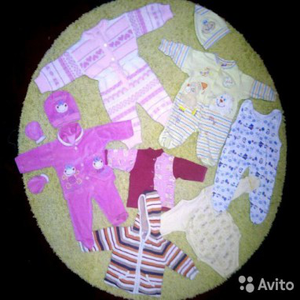

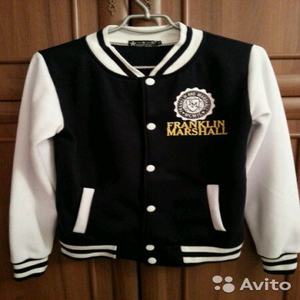

In [7]:
for j,x in topdull.head(2).iterrows():
    path = images_path + x['image']
    html = "<h4>Image : "+x['image']+" &nbsp;&nbsp;&nbsp; (Dullness : " + str(x['dullness']) +")</h4>"
    display(HTML(html))
    display(IMG.open(path).resize((300,300), IMG.ANTIALIAS))

In [8]:
features['whiteness'] = features['image'].apply(lambda x : perform_color_analysis(x, 'white'))
topdull = features.sort_values('whiteness', ascending = False)
topdull.head(5)

,image,dullness,whiteness
161,ff4eac25c128960c280770beece07a9c7394362c9a3439...,0.000,100.000
182,ff78807b19024ab58e6a6641d002d5d19b02c8ff9e2561...,0.000,100.000
543,ffde6ecd0a685a32b96abfbeeb131ef7adbef9939eb75d...,0.000,100.000
58,ff5ccef058c10618f6f5519641ab4a78f144730a8e906b...,0.000,100.000
333,ff7b17e39a635695c155a54cd2b3dcec62d0664c29468d...,0.035,99.965


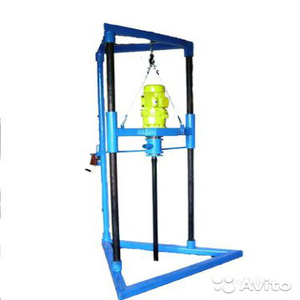

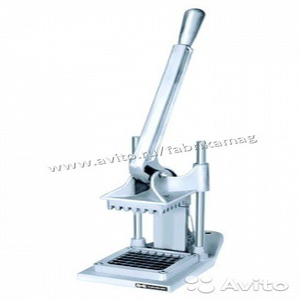

In [9]:
for j,x in topdull.head(2).iterrows():
    path = images_path + x['image']
    html = "<h4>Image : "+x['image']+" &nbsp;&nbsp;&nbsp; (Whiteness : " + str(x['whiteness']) +")</h4>"
    display(HTML(html))
    display(IMG.open(path).resize((300,300), IMG.ANTIALIAS))

In [10]:
def average_pixel_width(img):
    path = images_path + img 
    im = IMG.open(path)    
    im_array = np.asarray(im.convert(mode='L'))
    edges_sigma1 = feature.canny(im_array, sigma=3)
    apw = (float(np.sum(edges_sigma1)) / (im.size[0]*im.size[1]))
    return apw*100

In [11]:
features['average_pixel_width'] = features['image'].apply(average_pixel_width)
tempdf = features.sort_values('average_pixel_width').head()
tempdf

,image,dullness,whiteness,average_pixel_width
404,ff2e03f7d08e76c7b23350cf751d24c46d7d4bfcee1665...,0.0,0.0,0.117284
419,ff6b74306caa0ec74d32f0d2681888814d688201fc4c26...,0.0,0.0,0.150021
818,ff2894aaca1faafd8a9bd8ce12c073cba6854aaa54c773...,0.0,0.0,0.155816
632,ff2f1340c12986b12ebb4dd1b6d21076443afe934276f7...,0.0,0.0,0.156829
666,ff4339176bc721ef8e0fb55a0726a5f050ed834a2e2ec4...,0.0,0.0,0.234375


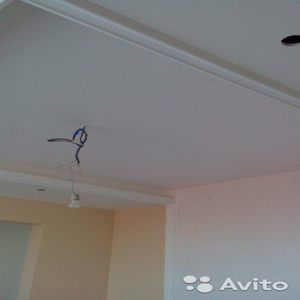

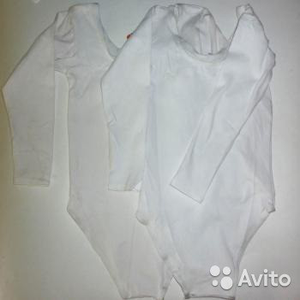

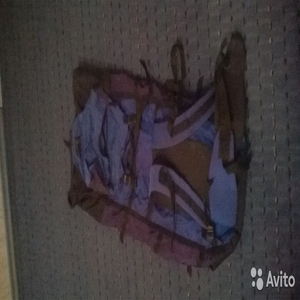

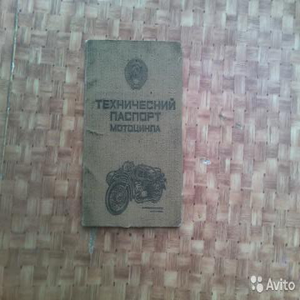

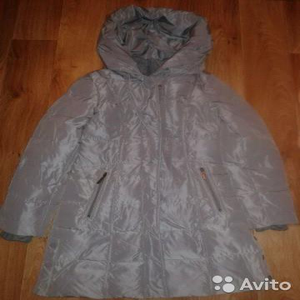

In [12]:
for j,x in tempdf.head(6).iterrows():
    path = images_path + x['image']
    html = "<h4>Image : "+x['image']+" &nbsp;&nbsp;&nbsp; (Average Pixel Width : " + str(x['average_pixel_width']) +")</h4>"
    display(HTML(html))
    display(IMG.open(path).resize((300,300), IMG.ANTIALIAS))

In [13]:
def get_dominant_color(img):
    path = images_path + img 
    img = cv2.imread(path)
    arr = np.float32(img)
    pixels = arr.reshape((-1, 3))

    n_colors = 5
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, labels, centroids = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)

    palette = np.uint8(centroids)
    quantized = palette[labels.flatten()]
    quantized = quantized.reshape(img.shape)

    dominant_color = palette[np.argmax(itemfreq(labels)[:, -1])]
    return dominant_color

features['dominant_color'] = features['image'].apply(get_dominant_color)
features.head(10)

,image,dullness,whiteness,average_pixel_width,dominant_color
0,ffcf3e992ef45bd0eca703c415fadfa643155585269f79...,0.465,66.580,2.140523,"[251, 253, 253]"
1,ffb27bec555e6c2b19dc04916a294c803d55d7f4163f1c...,14.175,61.130,1.442708,"[70, 89, 104]"
2,ffbbe808161a57ac47165836c369b8d12531831364f4fb...,0.000,0.000,2.136574,"[253, 219, 187]"
3,ffaafaa11ff73ddbcb95e0e95840a4cd44d5df3f3c1b87...,0.000,0.000,0.550347,"[116, 126, 153]"
4,ffdd4d73c916291ecc80b9dfb0317d616edaf0897a58e2...,6.105,0.000,10.251736,"[89, 106, 141]"
5,ff0113bc4a969c28de4e247c0dd5c1a08bda364ab1d5a6...,0.000,0.000,4.357639,"[171, 156, 137]"
6,ff7fb10a5ae21a8fbe94c884923a30e114821d8982517a...,39.220,39.225,3.628472,"[44, 59, 62]"
7,ff4b8404d1c087beb9f8873a5e0d022c6d6eccc58d9fcb...,0.000,47.025,2.832176,"[119, 136, 162]"
8,ffbcf1d40805b8d94d8c8dd043ac66acdb63f620979285...,7.695,0.000,3.929889,"[95, 123, 151]"
9,ff633ed5161cf459bdd92688cf8e43a13c45dfac0c97b3...,58.130,0.000,1.317708,"[176, 182, 178]"


In [14]:
features['dominant_red'] = features['dominant_color'].apply(lambda x: x[0]) / 255
features['dominant_green'] = features['dominant_color'].apply(lambda x: x[1]) / 255
features['dominant_blue'] = features['dominant_color'].apply(lambda x: x[2]) / 255
features[['dominant_red', 'dominant_green', 'dominant_blue']].head(5)

,dominant_red,dominant_green,dominant_blue
0,0.984314,0.992157,0.992157
1,0.274510,0.349020,0.407843
2,0.992157,0.858824,0.733333
3,0.454902,0.494118,0.600000
4,0.349020,0.415686,0.552941


In [15]:
def get_average_color(img):
    path = images_path + img 
    img = cv2.imread(path)
    average_color = [img[:, :, i].mean() for i in range(img.shape[-1])]
    return average_color

features['average_color'] = features['image'].apply(get_average_color)
features.head(10)

,image,dullness,whiteness,average_pixel_width,dominant_color,dominant_red,dominant_green,dominant_blue,average_color
0,ffcf3e992ef45bd0eca703c415fadfa643155585269f79...,0.465,66.580,2.140523,"[251, 253, 253]",0.984314,0.992157,0.992157,"[156.4436225, 193.821786492, 229.64046841]"
1,ffb27bec555e6c2b19dc04916a294c803d55d7f4163f1c...,14.175,61.130,1.442708,"[70, 89, 104]",0.274510,0.349020,0.407843,"[93.8788020833, 108.996132812, 117.961662326]"
2,ffbbe808161a57ac47165836c369b8d12531831364f4fb...,0.000,0.000,2.136574,"[253, 219, 187]",0.992157,0.858824,0.733333,"[221.498958333, 191.256527778, 162.074490741]"
3,ffaafaa11ff73ddbcb95e0e95840a4cd44d5df3f3c1b87...,0.000,0.000,0.550347,"[116, 126, 153]",0.454902,0.494118,0.600000,"[102.93103588, 113.279548611, 136.707060185]"
4,ffdd4d73c916291ecc80b9dfb0317d616edaf0897a58e2...,6.105,0.000,10.251736,"[89, 106, 141]",0.349020,0.415686,0.552941,"[91.9388946759, 106.056892361, 125.505086806]"
5,ff0113bc4a969c28de4e247c0dd5c1a08bda364ab1d5a6...,0.000,0.000,4.357639,"[171, 156, 137]",0.670588,0.611765,0.537255,"[113.54734375, 129.11009838, 143.227800926]"
6,ff7fb10a5ae21a8fbe94c884923a30e114821d8982517a...,39.220,39.225,3.628472,"[44, 59, 62]",0.172549,0.231373,0.243137,"[76.8670717593, 86.1943576389, 84.1542476852]"
7,ff4b8404d1c087beb9f8873a5e0d022c6d6eccc58d9fcb...,0.000,47.025,2.832176,"[119, 136, 162]",0.466667,0.533333,0.635294,"[135.436128472, 140.090405093, 143.346041667]"
8,ffbcf1d40805b8d94d8c8dd043ac66acdb63f620979285...,7.695,0.000,3.929889,"[95, 123, 151]",0.372549,0.482353,0.592157,"[78.3288130381, 89.0314960025, 125.793111931]"
9,ff633ed5161cf459bdd92688cf8e43a13c45dfac0c97b3...,58.130,0.000,1.317708,"[176, 182, 178]",0.690196,0.713725,0.698039,"[127.93583912, 134.377256944, 131.302818287]"


In [16]:
features['average_red'] = features['average_color'].apply(lambda x: x[0]) / 255
features['average_green'] = features['average_color'].apply(lambda x: x[1]) / 255
features['average_blue'] = features['average_color'].apply(lambda x: x[2]) / 255
features[['average_red', 'average_green', 'average_blue']].head(5)

,average_red,average_green,average_blue
0,0.613504,0.760085,0.900551
1,0.368152,0.427436,0.462595
2,0.868623,0.750026,0.635586
3,0.403651,0.444234,0.536106
4,0.360545,0.415909,0.492177


In [17]:
def getSize(filename):
    filename = images_path + filename
    st = os.stat(filename)
    return st.st_size

def getDimensions(filename):
    filename = images_path + filename
    img_size = IMG.open(filename).size
    return img_size 

In [18]:
features['image_size'] = features['image'].apply(getSize)
features['temp_size'] = features['image'].apply(getDimensions)
features['width'] = features['temp_size'].apply(lambda x : x[0])
features['height'] = features['temp_size'].apply(lambda x : x[1])
features = features.drop(['temp_size', 'average_color', 'dominant_color'], axis=1)
features.head()

,image,dullness,whiteness,average_pixel_width,dominant_red,dominant_green,dominant_blue,average_red,average_green,average_blue,image_size,width,height
0,ffcf3e992ef45bd0eca703c415fadfa643155585269f79...,0.465,66.58,2.140523,0.984314,0.992157,0.992157,0.613504,0.760085,0.900551,25309,561,360
1,ffb27bec555e6c2b19dc04916a294c803d55d7f4163f1c...,14.175,61.13,1.442708,0.274510,0.349020,0.407843,0.368152,0.427436,0.462595,50683,640,360
2,ffbbe808161a57ac47165836c369b8d12531831364f4fb...,0.000,0.00,2.136574,0.992157,0.858824,0.733333,0.868623,0.750026,0.635586,32219,480,360
3,ffaafaa11ff73ddbcb95e0e95840a4cd44d5df3f3c1b87...,0.000,0.00,0.550347,0.454902,0.494118,0.600000,0.403651,0.444234,0.536106,27043,360,480
4,ffdd4d73c916291ecc80b9dfb0317d616edaf0897a58e2...,6.105,0.00,10.251736,0.349020,0.415686,0.552941,0.360545,0.415909,0.492177,76505,480,360


In [19]:
def get_blurrness_score(image):
    path =  images_path + image 
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(image, cv2.CV_64F).var()
    return fm

In [20]:
features['blurrness'] = features['image'].apply(get_blurrness_score)
features[['image','blurrness']].head(5)

,image,blurrness
0,ffcf3e992ef45bd0eca703c415fadfa643155585269f79...,537.254722
1,ffb27bec555e6c2b19dc04916a294c803d55d7f4163f1c...,344.287202
2,ffbbe808161a57ac47165836c369b8d12531831364f4fb...,1433.412968
3,ffaafaa11ff73ddbcb95e0e95840a4cd44d5df3f3c1b87...,182.912440
4,ffdd4d73c916291ecc80b9dfb0317d616edaf0897a58e2...,1490.883546


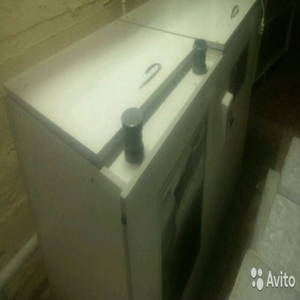

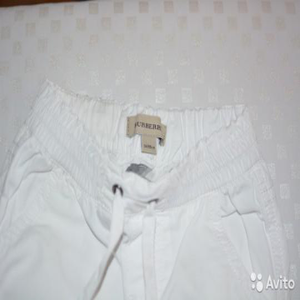

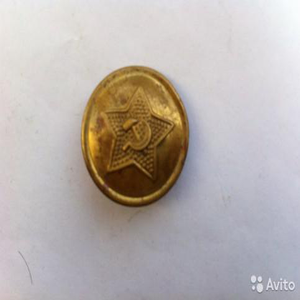

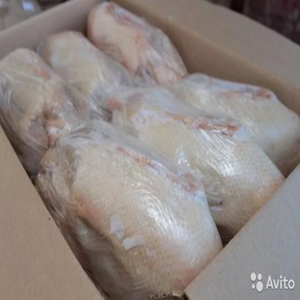

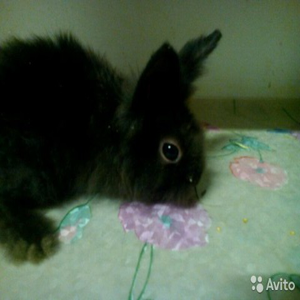

In [21]:
tempdf = features.sort_values('blurrness')
for y,x in tempdf.head(5).iterrows():
    path = images_path + x['image']
    html = "<h4>Image : "+x['image']+" &nbsp;&nbsp;&nbsp; (Blurrness : " + str(x['blurrness']) +")</h4>"
    display(HTML(html))
    display(IMG.open(path).resize((300,300), IMG.ANTIALIAS))

In [22]:
features.head()

,image,dullness,whiteness,average_pixel_width,dominant_red,dominant_green,dominant_blue,average_red,average_green,average_blue,image_size,width,height,blurrness
0,ffcf3e992ef45bd0eca703c415fadfa643155585269f79...,0.465,66.58,2.140523,0.984314,0.992157,0.992157,0.613504,0.760085,0.900551,25309,561,360,537.254722
1,ffb27bec555e6c2b19dc04916a294c803d55d7f4163f1c...,14.175,61.13,1.442708,0.274510,0.349020,0.407843,0.368152,0.427436,0.462595,50683,640,360,344.287202
2,ffbbe808161a57ac47165836c369b8d12531831364f4fb...,0.000,0.00,2.136574,0.992157,0.858824,0.733333,0.868623,0.750026,0.635586,32219,480,360,1433.412968
3,ffaafaa11ff73ddbcb95e0e95840a4cd44d5df3f3c1b87...,0.000,0.00,0.550347,0.454902,0.494118,0.600000,0.403651,0.444234,0.536106,27043,360,480,182.912440
4,ffdd4d73c916291ecc80b9dfb0317d616edaf0897a58e2...,6.105,0.00,10.251736,0.349020,0.415686,0.552941,0.360545,0.415909,0.492177,76505,480,360,1490.883546


In [23]:
features.to_csv("single.csv", index=False)